# del: Mini Challenge 1 with CIFAR-10 Dataset
- **Author**: Nils Fahrni
- **Date of Submission Overhaul**: 18.10.2024
- **Original Submission Date**: 18.04.2024

In [16]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "del_mc1"

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import KFold
from config import default_config
import torch.optim as optim
import numpy as np
import wandb

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="del_mc1"


#### Downloading Dataset
In order to work with the CIFAR10 Dataset, the dataset can be downloaded via the `torchvision` package. An important note at this step is that the CIFAR10 images are not normalized or standardized in any way at the point after downloading it. To later on learn the classes of the dataset it first is normalized on the metrics of the trainset.

In [17]:
unnormalized_transform = transforms.Compose([
    transforms.ToTensor()
])

unnormalized_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=unnormalized_transform)

def calculate_mean_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in dataloader:
        for i in range(3):
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

mean, std = calculate_mean_std(unnormalized_trainset)
print("Mean: ", mean)
print("Std: ", std)

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalized_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalized_transform)

Files already downloaded and verified
Mean:  tensor([0.4915, 0.4822, 0.4466])
Std:  tensor([0.2463, 0.2428, 0.2607])
Files already downloaded and verified
Files already downloaded and verified


#### Taking a look at the classes
To gain a grasp of how the data at hand looks, this following cell will plot the possible classes each with a random example from `CIFAR-10`.

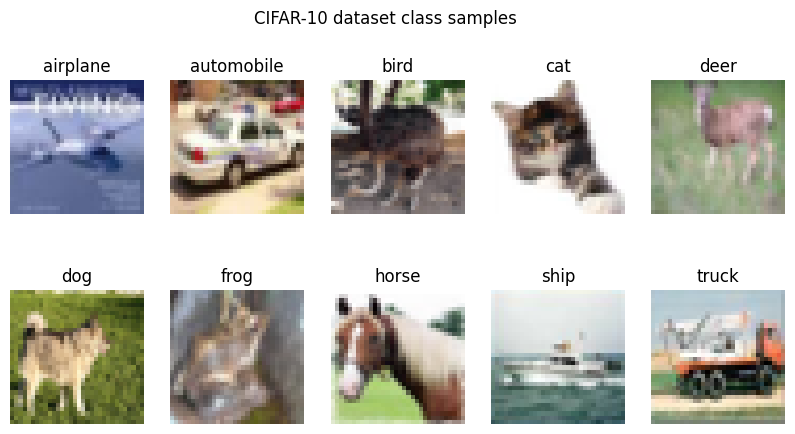

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) < 10:
    index = np.random.randint(0, len(cifar_trainset))
    image, label = cifar_trainset[index]
    if label not in independent_class_images:
        independent_class_images[label] = image

def reverse_normalize(tensor_img, mean, std):
    mean = mean.numpy()
    std = std.numpy()

    rev_img = tensor_img.numpy().transpose((1, 2, 0))
    rev_img = rev_img * std + mean
    rev_img = np.clip(rev_img, 0, 1)
    return rev_img

idx = 0
for i in range(2):
    for j in range(5):
        if idx in independent_class_images:
            img_to_plot = reverse_normalize(independent_class_images[idx], mean, std)
            axs[i, j].imshow(img_to_plot)
            axs[i, j].set_title(cifar_trainset.classes[idx])
            axs[i, j].axis('off')
        idx += 1

plt.show()

An observation at this point is the small size and low resolution of the images. This fact could limit the models' ability to capture small and intricate details which are certainly needed for accurate classification. I could imagine that the dataset proposes a rather hard task because some of the images for example depict logos or illustrations while others represnt an actual photograph of the object (class).

#### Color space distribution

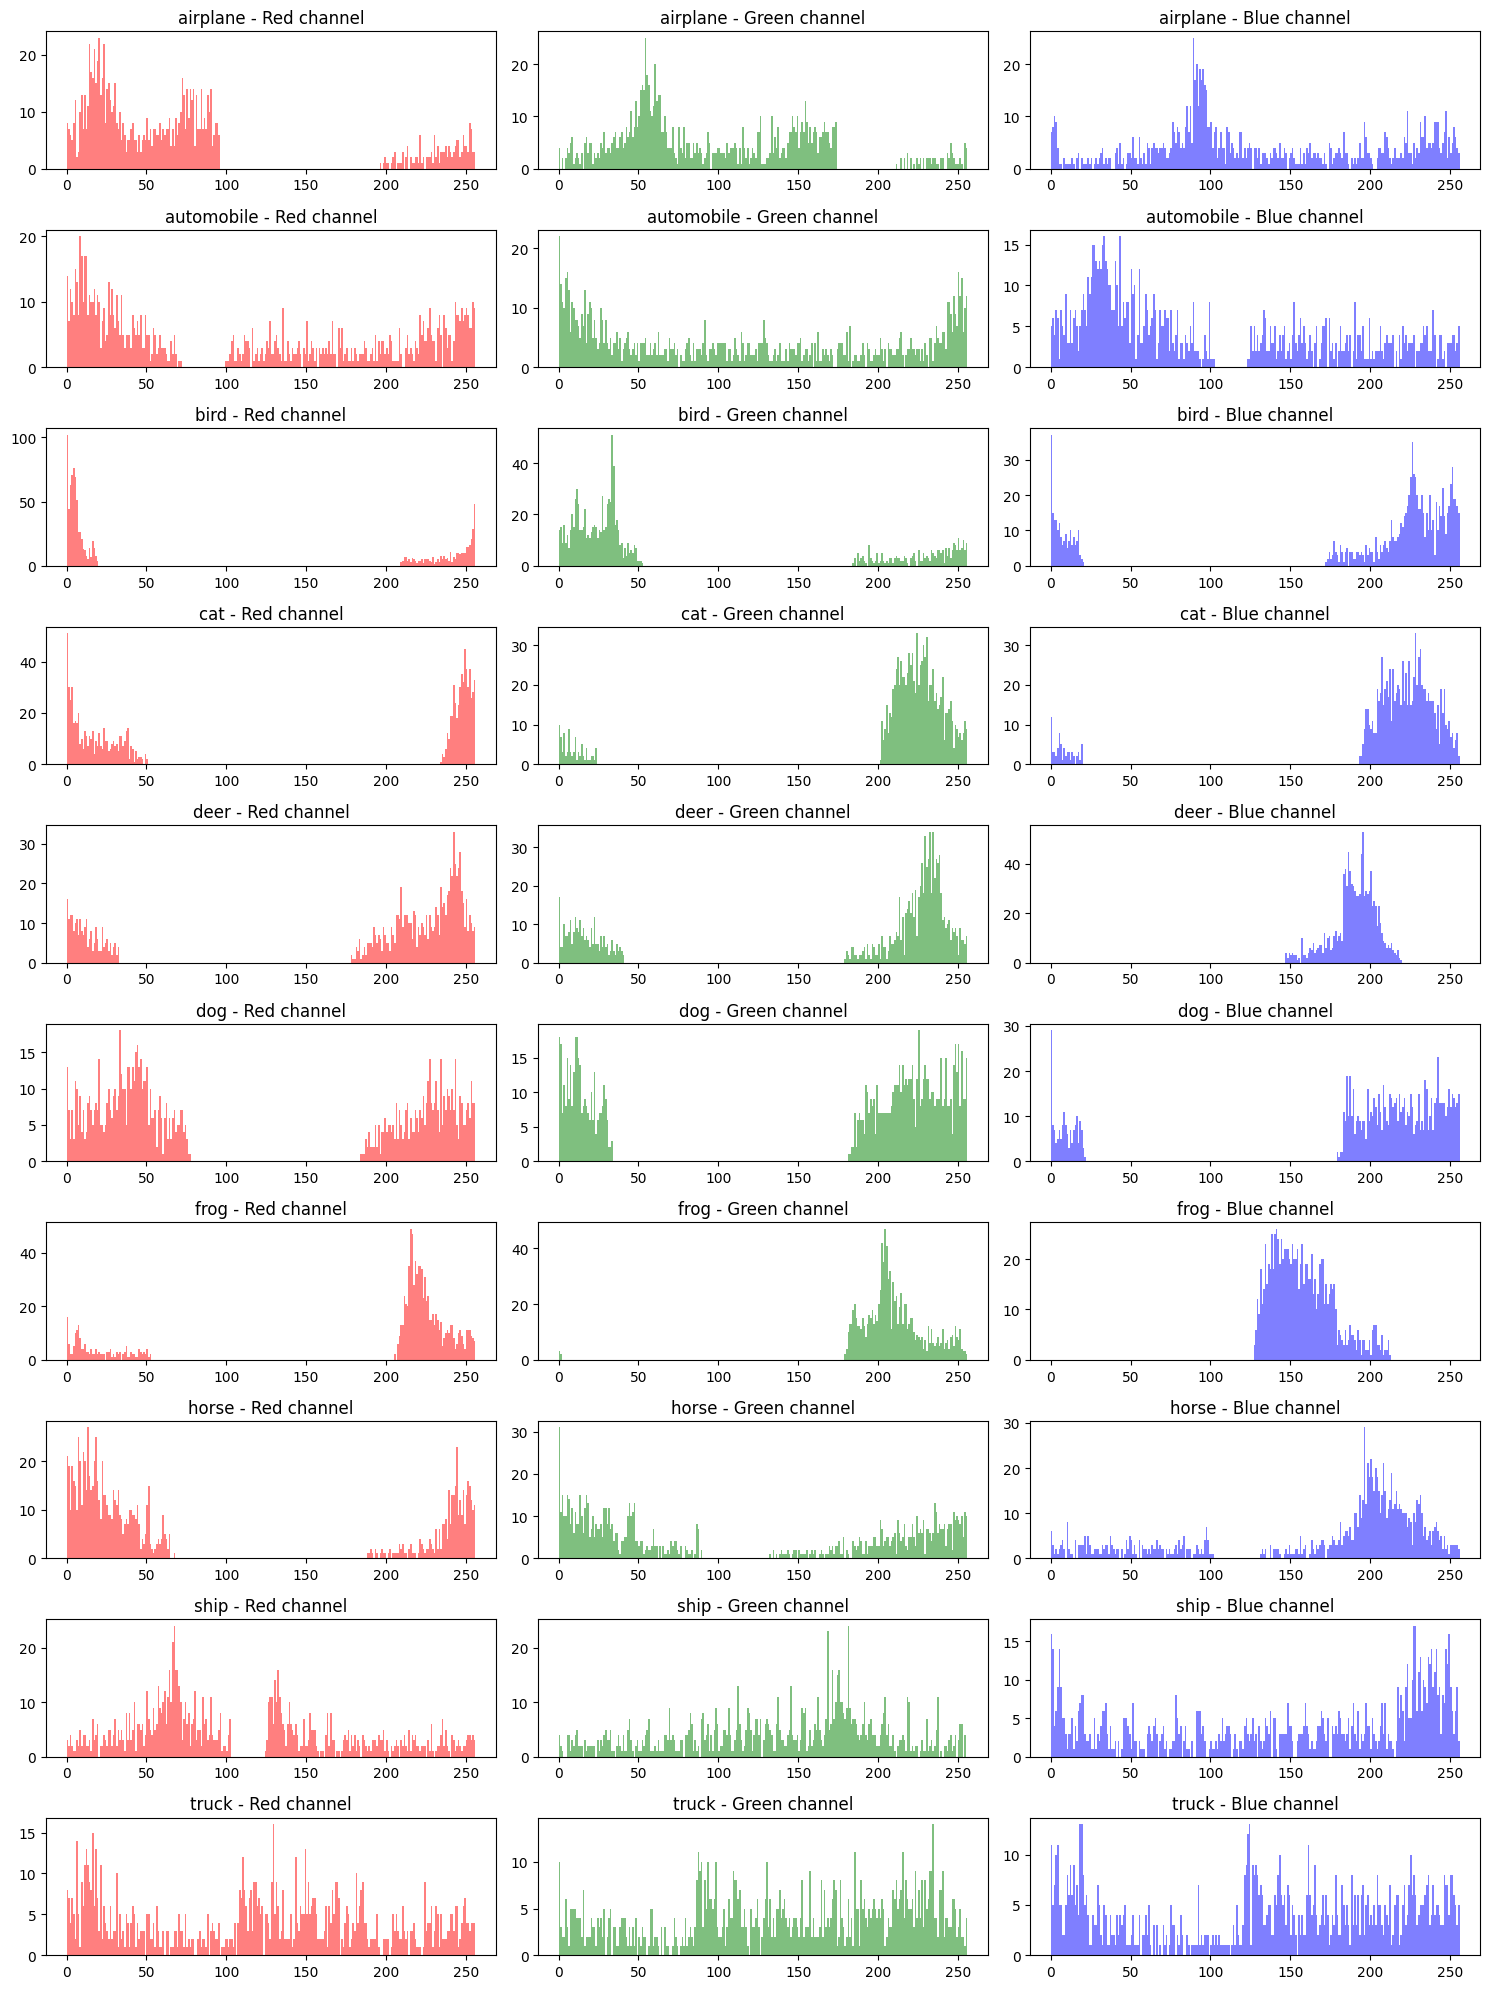

In [19]:
def compute_average_images(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    sum_images = [torch.zeros(3, 32, 32) for _ in range(10)]
    count_images = [0] * 10

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            sum_images[label] += image
            count_images[label] += 1

    avg_images = [sum_images[i] / count_images[i] for i in range(10)]
    return avg_images

avg_images = compute_average_images(cifar_trainset)

fig, axs = plt.subplots(10, 3, figsize=(15, 20))
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, avg_image in enumerate(avg_images):
    for j in range(3):
        scaled_image = (avg_image[j].numpy().ravel() * 255).astype(np.uint8)
        axs[i, j].hist(scaled_image, bins=256, color=['red', 'green', 'blue'][j], alpha=0.5, range=(0, 256))
        axs[i, j].set_title(f'{class_labels[i]} - {["Red", "Green", "Blue"][j]} channel')

plt.tight_layout()
plt.show()

The bird, deer, dog, and cat classes show a high concentration of pixel values at both the low and high ends of the RGB channels, with noticeable gaps in the middle, reflecting their natural coloring and varied textures. Notably, birds have a distinct tail in the high end of the blue channel, indicating a higher proportion of blue pixels, but fewer in the red and green channels compared to other animals, which tend to have a more balanced distribution across all colors. In contrast, classes like airplanes, ships, trucks, and automobiles have more evenly distributed color channels, likely due to uniform lighting, smoother surfaces, and the presence of large areas with consistent color tones like sky, road, or water. This leads to more gradual transitions in their RGB distributions.

#### Class Distribution

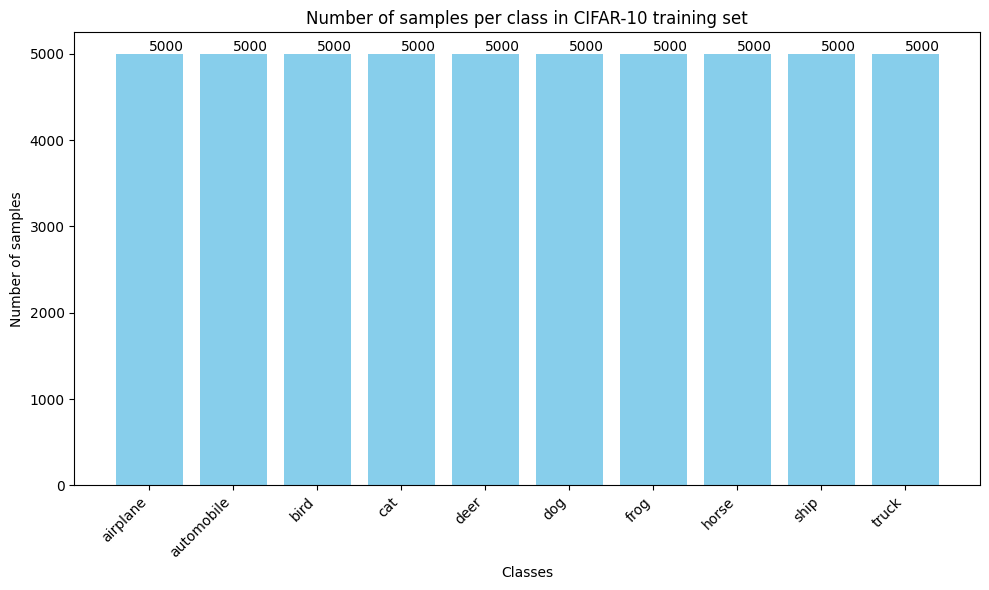

In [20]:
from collections import Counter
class_counts = Counter(target for _, target in cifar_trainset)

class_names = cifar_trainset.classes

classes = range(len(class_names))
counts = [class_counts[i] for i in classes]

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Number of samples per class in CIFAR-10 training set')
plt.xticks(classes, class_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()


The class distribution shows that the `CIFAR-10` dataset already is perfectly even distributed. No considerations therefore regarding a class imbalance must be made.

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Base Functions

### Train Method
The `train`-function takes a PyTorch model and other parameters to train it using the specified dataset (`data_loader`). It computes the loss using the given criterion, updates the model's weights using the optimizer, and calculates the training accuracy for multiclass classification. Periodically, based on the verbose_interval, it prints the average loss for that interval if verbose is set to True. Finally, it returns a dictionary containing the training accuracy and average loss over the entire dataset for the epoch.

In [22]:
def train(model: nn.Module,
          optimizer,
          criterion,
          data_loader: torch.utils.data.DataLoader,
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int=1):
    model.train()
    acc = MulticlassAccuracy(num_classes=n_classes).to(device)

    running_loss = 0.0
    verbose_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        class_pred = outputs.argmax(dim=1)
        acc.update(class_pred, labels)

        running_loss += loss.item()
        verbose_loss += loss.item()

        if verbose and (i+1) % verbose_interval == 0:
            avg_loss = verbose_loss / verbose_interval
            print(f'[Epoch {current_epoch}, Batch {i + 1}] loss: {avg_loss:.4f}')
            verbose_loss = 0.0

    train_loss = running_loss / len(data_loader)
    train_accuracy = acc.compute().item()

    return {"train_accuracy": train_accuracy, "train_loss": train_loss}

#### Test Method
The `test`-function on the other hand evaluates a PyTorch model's performance based on the test-set (`data_loader`). It calculates the test loss using the provided criterion and measures the accuracy of the model's predictions against true labels for multiclass classification, without updating the model's weights. The model is set to evaluation mode (model.eval()) to disable operations like dropout. It returns a dictionary containing the computed test accuracy and the average loss over the entire dataset.

In [23]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int):
    model.eval()
    accuracy = MulticlassAccuracy(num_classes=n_classes).to(device)
    test_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            class_pred = output.argmax(dim=1)
            accuracy.update(class_pred, target)

    test_loss /= len(data_loader)
    test_accuracy = accuracy.compute().item()

    return {"test_accuracy": test_accuracy, "test_loss": test_loss}

#### Model Training/Testing Orchestration
Lastly the `run_model_experiment`-function orchestrates the training and testing of a model across multiple epochs, using specified training and testing data loaders. If no optimizer is provided, it defaults to using SGD with a specified learning rate. The function allows for configurable weight initialization methods before training begins. During training, it integrates with Weights & Biases (wandb) for experiment tracking, logging both training and testing metrics per epoch. Optionally, it can monitor the model's gradients and parameters closely if watch is enabled. At the end of training, the function provides a link to the Weights & Biases project page for detailed visualization and analysis of the run.

In [24]:
def run_model_experiment(model: nn.Module,
                         criterion,
                         optimizer,
                         train_loader: torch.utils.data.DataLoader,
                         test_loader: torch.utils.data.DataLoader,
                         config=default_config,
                         weight_init: str = None,
                         learning_rate: float = 0.01,
                         n_epochs: int = 10,
                         n_classes: int = 10,
                         run_name: str = None,
                         tags: list = None,
                         verbose: bool = False,
                         watch: bool = False,
                         train_model: bool = True):
    torch.manual_seed(config["seed"])
    torch.cuda.manual_seed_all(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None and train_model:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if weight_init is not None:
        for m in model.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                if weight_init == 'kaiming':
                    torch.nn.init.kaiming_normal_(m.weight)
                elif weight_init == 'xavier':
                    torch.nn.init.xavier_normal_(m.weight)
                elif weight_init == 'normal':
                    mean = m.weight.mean().item()
                    std = m.weight.std().item()
                    torch.nn.init.normal_(m.weight, mean, std)
                else:
                    raise ValueError(f"Unknown weight initialization method: {weight_init}")

    model.to(device)

    with wandb.init(project="del-mc1",
                    name=run_name if run_name is not None else model.__class__.__name__,
                    config=config,
                    tags=tags if tags is not None else None,
                    settings=wandb.Settings(disable_job_creation=True)) as run:

        print(f"--- Model Architecture ---")
        print(model, '\n')

        print(f"--- Running Experiment: {run_name} on {device} ---")

        if watch:
            wandb.watch(model, criterion=criterion, log="all", log_graph=True, log_freq=1)

        if train_model:
            for epoch in range(1, n_epochs + 1):
                train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes,
                                      current_epoch=epoch, verbose=verbose)
                test_metrics = test(model, criterion, test_loader, device, n_classes)
                wandb.log({**train_metrics, **test_metrics, "epoch": epoch})

                print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")
        else:
            print("Skipping training, running transfer learning testing only.")
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log(test_metrics)
            print(f"Test accuracy: {test_metrics['test_accuracy']:.3f}")

        if watch:
            wandb.unwatch(model)

        print(f"Experiment completed. View run at: https://wandb.ai/{run.entity}/{run.project}/runs/{run.id}\n")


In [25]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True, num_workers=4) 
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False, num_workers=4)

## Base Model
The Baseline Model `BaseCNN` is being used to go through every experiment. It's a simple CNN model which has been held rather shallow for efficiency's sake. The goal during the following analyses will be to measure and see the impact different hyperparameters and related settings have. The effects of those analyses should also be measurable within such a simplistic model.

The model consists of the following architecture:
1. **Convolutional Layers**: 
    - The model starts with two convolutional layers that extract spatial hierarchies of features from the input image. The first convolutional layer transforms the 3-channel RGB image (`32x32x3`) into `32` feature maps, applying a `3x3` kernel with padding to preserve the spatial dimensions.
    - The second convolutional layer increases the number of feature maps to `64` while maintaining the same kernel size and padding strategy. These convolutional layers learn local patterns such as edges, textures, and shapes in the image.

2. **Non-linear Activation (ReLU)**:
    - After each convolutional layer, a ReLU (Rectified Linear Unit) activation function is applied to introduce non-linearity.

3. **Pooling Layers**:
    - Each convolutional block is followed by a `MaxPooling` layer with a `2x2` kernel, which reduces the spatial dimensions by a factor of 2 (`32x32` to `16x16`, and then `16x16` to `8x8`). This helps reduce the computational cost and also somewhat helps to mitigate overfitting by downsampling the feature maps.

4. **Latent Space Representation**:
    - After the convolutional and pooling operations, the `8x8x64` feature maps are flattened into a 1D vector of size `64 * 8 * 8` (`4096`). This vector is a compressed representation of the input image, often referred to as the latent space. The latent space captures the high-level features learned by the convolutional layers, which are then passed to the fully connected layers for classification.

5. **Fully Connected Layers**:
    - The fully connected layers (Linear layers) follow the flattened latent space. The first fully connected layer reduces the feature vector size from `4096` to `512`, the second layer further reduces it to `128`, and the final output layer reduces it to `10`. The number `10` corresponds to the number of classes (e.g., for CIFAR-10).

6. **Output Layer**:
    - The final layer produces `10` output neurons, representing the class logits for the `10` classes. These logits can later be passed through a softmax activation to generate class probabilities during inference.

In [26]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),

        nn.Linear(64 * 8 * 8, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

### Customizable Base Model
For the following experiments and analyses, this following function will help to configure new models based on the `BaseCNN`. The `CustomBaseCNN` method helps to extend the `BaseCNN` in a fast manner so that experiments can be executed fast and debugged fast while offering the same base for all analyses so there is a common ground for comparison.

In [27]:
def CustomBaseCNN(filters_per_layer=[32, 64], 
                  kernel_sizes=[3, 3], 
                  strides=[1, 1],
                  paddings=[1, 1], 
                  padding_modes=['zeros', 'zeros'],
                  maxpool_sizes=[(2, 2), (2, 2)],
                  fc_sizes=[512, 128, 10],
                  use_dropout=False,
                  dropout_rate=0.5,
                  use_batchnorm=False,
                  batchnorm_momentum=0.1):
    layers = []

    num_conv_layers = len(filters_per_layer)
    num_fc_layers = len(fc_sizes)

    input_channels = 3
    output_size = 32
    
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(input_channels, 
                                filters_per_layer[i], 
                                kernel_size=kernel_sizes[i], 
                                stride=strides[i], 
                                padding=paddings[i], 
                                padding_mode=padding_modes[i]))
        
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(filters_per_layer[i], momentum=batchnorm_momentum))
        
        layers.append(nn.ReLU())
        
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        if maxpool_sizes[i] is not None:
            layers.append(nn.MaxPool2d(maxpool_sizes[i]))
            output_size = (output_size - kernel_sizes[i] + 2*paddings[i]) // strides[i] + 1
            output_size = output_size // maxpool_sizes[i][0]

        input_channels = filters_per_layer[i]

    layers.append(nn.Flatten())

    input_size = input_channels * output_size * output_size

    for i in range(num_fc_layers):
        layers.append(nn.Linear(input_size, fc_sizes[i]))
        
        if i < num_fc_layers - 1:
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(fc_sizes[i], momentum=batchnorm_momentum))
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            input_size = fc_sizes[i]

    return nn.Sequential(*layers)


## Overfit Testing
The first exploration done in the Mini Challenge aims to validate the Baseline Model by only propagating and learning 16 samples. This will show if the model is capable of learning. The expectation here is that the model will overfit (or just reach perfect accuracy) because the subset is so small.

It makes sense to look at a couple of samples (`16` in this experiment) to validate that the model can learn. If I would only run this test on a single sample, the model could also just be initialized with random weights that already correctly classify the single sample. This way we can make sure that it actually learns. 

The gradient gets updated after every forward pass (`batch_size=1`), so the gradient updates immediately try to minimize the error of the current sample. I hope to nudge the model into memorizing single samples in a faster way, with less epochs, through this.

In [13]:
num_samples = 16

subsample_subset_train = torch.utils.data.Subset(cifar_trainset, list(range(num_samples)))
subsample_loader_train = torch.utils.data.DataLoader(subsample_subset_train, batch_size=1, shuffle=False)

run_model_experiment(BaseCNN(), 
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None, 
                     train_loader=subsample_loader_train, 
                     test_loader=subsample_loader_train,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=20,
                     n_classes=10,
                     run_name="Overfit_Test")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment: Overfit_Test on cuda ---
Epoch 1 - Train accuracy: 0.062, Test accuracy: 0.312
Epoch 2 - Train accuracy: 0.250, Test accuracy: 0.312
Epoch 3 - Train accuracy: 0.250, Test accuracy: 0.250
Epoch 4 - Train accuracy: 0.250, Test accuracy: 0.250
Epoch 5 - Train accuracy: 0.188, Test accuracy: 0.250
Epoch 6 - Train accuracy: 0.188, Test accuracy: 0.5

In [14]:
%wandb okaynils/del-mc1/reports/Overfitting-Example--Vmlldzo3NTA2NDM5

### Observations
- The model can memorize the small subset of 16 samples within 50 epochs and reaches an accuracy of `100%`
- The loss looks to be stable and smooth

### Interpretation
- By updating the gradient after every sample, the model memorizes each sample quickly, within just under 20 epochs
- The training process however seems to work. The weights inside the model minimize the loss on the training data

## Exploring Weight-Initialization
There are numerous ways to initialize the weights of a network before going through the training process. In this exploration I explicitly looked at the impact that `kaiming_normal_`, `xavier_normal_` and `normal_` have on the baseline model.

### Drawing Weights from Normal Distribution
The `normal_` weight initialization method samples weights from the normal distribution $\mathcal{N}(\text{mean},\text{std}^2)$. The mean and standard deviation used to form the normal distribution are defaulted to `mean: float = 0.0` and `std: float = 1.0`.

### Xavier Weight Initialization
This initialization method takes a similar approach but samples and draws values from a slightly altered normal distribution, namely the **Xavier Normal Distribution**: 
$$\mathcal{N}(0,\text{std}^2)$$
where $$\text{std}=\text{gain}\times\sqrt{\frac{2}{\text{fan\_in}+\text{fan\_out}}}$$

Where
- $\text{gain}$ is an optional scaling factor (defaulted to `1.0`)
- $\text{fan\_in}$ is the number of input units in the weight tensor
- $\text{fan\_out}$ is the number of output units in the weight tensor

The key idea behind this formula is to maintain the variance of activations and gradients across layers. The $\sqrt{2 / (\text{fan\_in} +\text{fan\_out})}$ term helps balance the distribution of the initial weights based on the layer's size. Xavier weight initialization is especially made for symmetric activation functions, activation functions that are centered around `0` and activations with a finite output range (such as $\tanh$ ranged by `[-1,1]` and $\text{sigmoid}$ ranged by `[0,1]`).

### Kaiming Weight Initialization
The third weight initialization method that was looked at in this mini challenge was the Kaiming Initialization. This method also draws the initialization weights from a slightly modified normal distribution where the standard deviation in $\mathcal{N}(0,\text{std}^2)$ is calculated as $$\text{std}=\frac{\text{gain}}{\sqrt{\text{fan\_mode}}}$$

Where
- $\text{gain}$ is an optional scaling factor (defaulted to `1.0`)
- $\text{fan\_mode}$ is either the number of input units in the weight tensor or the number of output units in the weight tensor or the (so essentially either $\text{fan\_in}$ or $\text{fan\_out}$, in PyTorch this is defaulted to $\text{fan\_in}$). This characteristic will either preserve the variance towards the forward pass ($\text{fan\_in}$) or towards the backward pass ($\text{fan\_out}$).

This initialization also tries to keep the same variance of activations across layers but is especially beneficial for layers that go through a $\text{ReLU}$ activation. This is because Kaiming takes the non-linearity of $\text{ReLU}$ into account. The Kaiming Weight Initialization method is therefore very similar to the Xavier Weight Initialization, except it's especially designed for non-symmetric activations and activations with unbounded positive outputs (such as $\text{ReLU}$).

After I read up on these methods I found that this also has a historic background: Back in 2010, when the paper introducing **Xavier Init** ["Understanding the difficulty of training deep feedforward neural networks" by Glorot & Bengio](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) was released, models widely used $\tanh$ and $\text{sigmoid}$ activations. Later in 2015, Kaiming He et al.'s paper ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](https://arxiv.org/pdf/1502.01852) introduced their specific initialization method after $\text{ReLU}$ became more widely used since Geoffrey Hinton et al. (who recently won the Nobel Prize) established the "Recitfied Linear Unit" as a widely applicable and effective activation.

### Running the Weight Init Experiments

Each of the three experiments at hand were concluded on the `BaseCNN` Model and the default hyperparameter settings (`learning_rate=0.01`).

In [64]:
run_model_experiment(model=BaseCNN(),
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     n_classes=10,
                     weight_init='kaiming',
                     run_name="Kaiming_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kaiming_Init ---
Epoch 1 - Train accuracy: 0.431, Test accuracy: 0.468
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.518
Epoch 3 - Train accuracy: 0.610, Test accuracy: 0.579
Epoch 4 - Train accuracy: 0.648, Test accuracy: 0.608
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.620
Epoch 6 - Train accuracy: 0.710, Test accuracy: 0.579
Epoch 

In [65]:
run_model_experiment(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='xavier',
             run_name="Xavier_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Xavier_Init ---
Epoch 1 - Train accuracy: 0.384, Test accuracy: 0.426
Epoch 2 - Train accuracy: 0.513, Test accuracy: 0.500
Epoch 3 - Train accuracy: 0.570, Test accuracy: 0.561
Epoch 4 - Train accuracy: 0.608, Test accuracy: 0.588
Epoch 5 - Train accuracy: 0.643, Test accuracy: 0.609
Epoch 6 - Train accuracy: 0.669, Test accuracy: 0.592
Epoch 7

In [66]:
run_model_experiment(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='normal',
             run_name="Normal_Init")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Normal_Init ---
Epoch 1 - Train accuracy: 0.270, Test accuracy: 0.317
Epoch 2 - Train accuracy: 0.415, Test accuracy: 0.363
Epoch 3 - Train accuracy: 0.483, Test accuracy: 0.501
Epoch 4 - Train accuracy: 0.529, Test accuracy: 0.532
Epoch 5 - Train accuracy: 0.569, Test accuracy: 0.544
Epoch 6 - Train accuracy: 0.601, Test accuracy: 0.561
Epoch 7

In [15]:
%wandb okaynils/del-mc1/reports/Weight-Initialization--Vmlldzo3NTA2NTk5

### Observations
- The three methods follow a stable loss throughout 30 epochs on the training set.
- Between epoch 10-15 the model seems to start to overfit within all explored initialization methods.
- The `Xavier`- and `Normal`-Initialization methods both show some harsh instability in the loss between epoch 25 and 26. The accuracy also dents in at during epoch 25 and 26.
- The model corrects the "loss jumps" right after they occur  

### Interpretation
- The sudden increase of loss and the dent in accuracy at epoch 25 could mean that in this epoch some noisy outlier was learned which led to a less generalized performance.
- Another interpretation or explanation for the sudden loss jump may be that some of the gradients at the observed epochs we're too numerically unstable. In smaller networks, things like **gradient explosion** are prone to occur. 

## Analyzing Model Depth
Within this experiment the `BaseCNN` will get extended with further **fully connected linear layers**. The models therefore become more complex and it is expected that we should see better results as they can capture a wider range of details with their increase in complexity. This increase also comes with problems such as overfitting as we could approach an **interpolation point** by adding more and more parameters.

### Extending Linear Layer Depth
The following three architectures were trained:
- **`depth_3_mlp`**: `BaseCNN` Architecture with `3` Linear Layers in the following unit order: `4096`, `512`, `10`
- **`depth_4_mlp`**: `BaseCNN` Architecture with `4` Linear Layers in the following unit order: `4096`, `512`, `256`, `10`
- **`depth_5_mlp`**: `BaseCNN` Architecture with `5` Linear Layers in the following unit order: `4096`, `512`, `256`, `128`, `10`

In [13]:
depth_3_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 10])
depth_4_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 256, 10])
depth_5_mlp = CustomBaseCNN(fc_sizes=[4096, 512, 256, 128, 10])

run_model_experiment(model=depth_3_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_3_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=10, bias=True)
) 

--- Running Experiment Depth_3_MLP ---
Epoch 1 - Train accuracy: 0.461, Test accuracy: 0.521
Epoch 2 - Train accuracy: 0.589, Test accuracy: 0.551
Epoch 3 - Train accuracy: 0.651, Test accuracy: 0.551
Epoch 4 - Train accuracy: 0.697, Test accuracy: 0.631
Epoch 5 - Train accuracy: 0.735, Test accuracy: 0.606
Epoch 6 - Train accuracy: 0.776, Test accuracy: 0.600
Epoch

In [14]:
run_model_experiment(model=depth_4_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_4_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Depth_4_MLP ---
Epoch 1 - Train accuracy: 0.447, Test accuracy: 0.482
Epoch 2 - Train accuracy: 0.577, Test accuracy: 0.544
Epoch 3 - Train accuracy: 0.639, Test accuracy: 0.555
Epoch 4 - Train accuracy: 0.686, Test accuracy: 0.610
Epoch 5 - Train accuracy: 0.730, Test

In [15]:
run_model_experiment(model=depth_5_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_5_MLP")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_5_MLP ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.469
Epoch 2 - Train accuracy: 0.560, Test accuracy: 0.553
Epoch 3 - Train accuracy: 0.627, Test accuracy: 0.544
Epoch 4 - Train

In [7]:
%wandb okaynils/del-mc1/reports/FC-Model-Depth--Vmlldzo3NTA3MjM2

### Observations
- The model with `5` dense layers seems to overfit the fastest (with the first sign at around epoch 9). This can be seen within the loss and accuracy
- All three explored variants show a smooth and steady increase in loss after epoch `12` or whenever the train loss converges to `0`
- The models with dense layer depth `4` and `3` don't show as big of a loss spike as the most complex model with `5` fully connected layers
- The results show a relative clear hierarchy within the loss after epoch `12`:
    - FC Depth `5` results in the highest loss
    - Then FC `4`
    - And at last FC Depth `3`
- All three models converge to around the same `test_accuracy` of `~70%`

### Interpretation
- The most complex model probably suffered a bit from it's complexity/capacity when it probably memorized some noise or outlier in epoch 9 since this also instantly resulted in a downspike inside the `test_accuracy`
- The smooth and steady loss increase goes hand in hand with the convergence of the train and test accuracy, the model at that point seems to only learn more noise rather than general patterns
- I interpret the fact that all models here reach about the same score as a sign that adding further depth in the dense layers doesn't really help to capture patterns more effectively. All three models seem to be "capped" by the preceding Convolutional Layer(s) (whose configurations are the same across all three models).

To see if the last assumption has truth to it, I will also explore the effect of adding more Convolutional Layers:

### Extending Convolutional Layer Depth

The following three architectures were trained:
- **`depth_3_cnn`**: `BaseCNN` Architecture with `3` Conv Layers in the following filter order: `32`, `64`, `128`
- **`depth_4_cnn`**: `BaseCNN` Architecture with `4` Conv Layers in the following unit order: `32`, `64`, `128`, `256`
- **`depth_5_cnn`**: `BaseCNN` Architecture with `5` Conv Layers in the following unit order: `32`, `64`, `128`, `256`, `512`

In [24]:
depth_3_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128], kernel_sizes=[3]*3, strides=[1]*3, paddings=[1]*3, maxpool_sizes=[(2, 2), None, (2, 2)])
depth_4_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128, 256], kernel_sizes=[3]*4, strides=[1]*4, paddings=[1]*4, maxpool_sizes=[(2, 2), None, None, (2, 2)])
depth_5_cnn = CustomBaseCNN(filters_per_layer=[32, 64, 128, 256, 512], kernel_sizes=[3]*5, strides=[1]*5, paddings=[1]*5, maxpool_sizes=[(2, 2), None, None, None, (2, 2)])

run_model_experiment(model=depth_3_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=128, bias=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_3_CNN ---
Epoch 1 - Train accuracy: 0.444, Test accuracy: 0.446
Epoch 2 - Train accuracy: 0.571, Test accuracy: 0.560
Epoch 3 - Train accuracy: 0.636, Test accuracy: 0.518
Epoch 4 - Train accuracy: 0.681, Test accuracy: 0.626
Epoch

In [25]:
run_model_experiment(model=depth_4_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_4_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=16384, out_features=512, bias=True)
  (12): ReLU()
  (13): Linear(in_features=512, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_4_CNN ---
Epoch 1 - Train accuracy: 0.430, Test accuracy: 0.396
Epoch 2 - Train accuracy: 0.578, Test accuracy: 0.530
Epoch 3 - Train accur

In [26]:
run_model_experiment(model=depth_5_cnn,
                     criterion=nn.CrossEntropyLoss(),
                     optimizer=None,
                     train_loader=train_loader,
                     test_loader=test_loader,
                     config=default_config,
                     learning_rate=0.01,
                     n_epochs=30,
                     run_name="Depth_5_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=128, bias=True)
  (16): ReLU()
  (17): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Depth_5_CNN ---
Epoch 1 - Train accuracy: 0.419, Test 

In [5]:
%wandb okaynils/del-mc1/reports/Conv-Model-Depth--Vmlldzo5NzU0NTg3

### Observations
- The model with `5` Conv-Layers reaches the lowest test loss and highest test score
- All three models again show a relatively clear hierarchy regarding their complexity 

### Interpretation
- The assumption of adding more linear layers seems to hold its truth; The most complex model here is able to reach the highest score
- Decreasing the number of Convolutional Layers (and analogically number of filters) shows to negatively impact the model performances

## Analyzing Number of Filters
This experiment, in contrast to the Depth Analysis, now explicitly focuses on the filters inside the Convolutional Layer(s). To make sure our complexity this time won't be limited by a single `conv`-layer, I defined three models with **two** Convolutional Layers and the **two** linear layers from the `BaseCNN` "default setting".

### Models
The following three architectures were trained:
- **`filter_8_16_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `8` Filters for the first layer and `16` for the second.
- **`filter_16_32_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `16` Filters for the first layer and `32` for the second.
- **`filter_32_64_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `32` Filters for the first layer and `64` for the second.

The other hyperparameters for the Convolutional Layers (kernel size, stride and padding) stay the same since they will be explored independently later on. Between the Convolutional Layers the model uses the ReLU activation function and then pools the outputs with a `MaxPool2d`-Layer in a `(2, 2)` Kernel Size. The order here doesn't really matter since both these functions do commute.

In [13]:
filter_16_32_cnn = CustomBaseCNN(filters_per_layer=[16, 32], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_64_128_cnn = CustomBaseCNN(filters_per_layer=[64, 128], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_256_512_cnn = CustomBaseCNN(filters_per_layer=[256, 512], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])

run_model_experiment(model=filter_16_32_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_16_32_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2048, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_16_32_CNN ---
Epoch 1 - Train accuracy: 0.417, Test accuracy: 0.392
Epoch 2 - Train accuracy: 0.537, Test accuracy: 0.521
Epoch 3 - Train accuracy: 0.587, Test accuracy: 0.568
Epoch 4 - Train accuracy: 0.622, Test accuracy: 0.594
Epoch 5 - Train accuracy: 0.652, Test accuracy: 0.589
Epoch 6 - Train accuracy: 0.676, Tes

In [14]:
run_model_experiment(model=filter_64_128_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_64_128_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=8192, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_64_128_CNN ---
Epoch 1 - Train accuracy: 0.440, Test accuracy: 0.458
Epoch 2 - Train accuracy: 0.572, Test accuracy: 0.540
Epoch 3 - Train accuracy: 0.633, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.677, Test accuracy: 0.630
Epoch 5 - Train accuracy: 0.715, Test accuracy: 0.607
Epoch 6 - Train accuracy: 0.747, T

In [15]:
run_model_experiment(model=filter_256_512_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_256_512_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Filter_256_512_CNN ---
Epoch 1 - Train accuracy: 0.483, Test accuracy: 0.442
Epoch 2 - Train accuracy: 0.628, Test accuracy: 0.576
Epoch 3 - Train accuracy: 0.696, Test accuracy: 0.582
Epoch 4 - Train accuracy: 0.748, Test accuracy: 0.661
Epoch 5 - Train accuracy: 0.796, Test accuracy: 0.619
Epoch 6 - Train accuracy: 0.84

In [8]:
%wandb okaynils/del-mc1/reports/Number-of-Filters--Vmlldzo3NTE3Njc3

### Observations
- The distinction of complexity also emerges here:
    - The model with the highest filter configuration is able to reach the highest score
    - Following the model with two Conv Layers of `64` and then `128` filters
    - And at last with `~66%` the model with `16` to `32` filters 
- An interesting observation is that in the test loss all three models experienced some sort of spike but all at offset at a different epoch:
    - The `Filter_256_512_CNN` at epoch 6
    - The `Filter_64_128_CNN`, 8 epochs later, at epoch 14
    - And the `Filter_16_32_CNN`, again 8 epochs later, at epoch 22
    After these spikes, the corresponding models start to converge in the train loss and accuracy

### Interpretation
- The score distinctions again reflect the capacity of each model; Hence, the most complex model (with the most feature extraction parameters) can reach the highest score
    - The convergence of the training loss after these spikes indicates that the models are successfully optimizing for the training set. However, the different timings of the test loss spikes likely reflect each model's varying capacity to generalize, where larger models overfit more quickly and display sharper test loss spikes, while the smaller models maintain better generalization for a longer period.
- Overall I think it's fair to say that the task at hand benefits from a high number of feature extractors (filters)

## Analyzing Kernel Size
In this section the Kernel Size of the filters will be explored. For this analysis again three models, distinctive in their kernel size, were trained.

### Models
The following three architectures were trained:
- **`kernel_3_cnn`**: `BaseCNN` Architecture with a `3x3` Kernel Size and `padding=1` in the Convolutional Layer
- **`kernel_5_cnn`**: `BaseCNN` Architecture with a `5x5` Kernel Size and `padding=2` in the Convolutional Layer
- **`kernel_7_cnn`**: `BaseCNN` Architecture with a `7x7` Kernel Size and `padding=3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16` and `stride=1`.

In [17]:
kernel_3_cnn = CustomBaseCNN(kernel_sizes=[3, 3])
kernel_5_cnn = CustomBaseCNN(kernel_sizes=[5, 5])
kernel_7_cnn = CustomBaseCNN(kernel_sizes=[7, 7])

run_model_experiment(model=kernel_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_3_CNN ---
Epoch 1 - Train accuracy: 0.429, Test accuracy: 0.451
Epoch 2 - Train accuracy: 0.555, Test accuracy: 0.535
Epoch 3 - Train accuracy: 0.613, Test accuracy: 0.597
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.611
Epoch 5 - Train accuracy: 0.682, Test accuracy: 0.613
Epoch 6 - Train accuracy: 0.712, Test ac

In [18]:

run_model_experiment(model=kernel_5_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_5_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=2304, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_5_CNN ---
Epoch 1 - Train accuracy: 0.422, Test accuracy: 0.451
Epoch 2 - Train accuracy: 0.546, Test accuracy: 0.513
Epoch 3 - Train accuracy: 0.606, Test accuracy: 0.547
Epoch 4 - Train accuracy: 0.645, Test accuracy: 0.625
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.587
Epoch 6 - Train accuracy: 0.709, Test ac

In [19]:
run_model_experiment(model=kernel_7_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_7_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1600, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Kernel_7_CNN ---
Epoch 1 - Train accuracy: 0.403, Test accuracy: 0.384
Epoch 2 - Train accuracy: 0.530, Test accuracy: 0.498
Epoch 3 - Train accuracy: 0.587, Test accuracy: 0.544
Epoch 4 - Train accuracy: 0.628, Test accuracy: 0.592
Epoch 5 - Train accuracy: 0.659, Test accuracy: 0.561
Epoch 6 - Train accuracy: 0.688, Test ac

In [9]:
%wandb okaynils/del-mc1/reports/Kernel-Size--Vmlldzo3NTE3NzIy

### Observations
- This experiment now doesn't show a clear hierarchy anymore:
    - The CNN with `3x3` kernels converges the fastest
    - The CNN with `5x5` kernels comes in at the second place but reaches a higher test accuracy overall
    - The CNN with `7x7` kernels showns signs of convergence about `4` epochs later
- The test loss seems most stable for the CNNs with either a `3x3` kernel size or `5x5` kernel size
- The model with the largest kernel size shows large spikes in the test loss

### Interpretation
- It looks like the sweet spot to extract features in the CIFAR-10 dataset is at `5x5` kernels. This kernel seems to have a receptive field large enough to generalize well on some common features in the CIFAR-10 classes and small enough to still extract the main physical features of each CIFAR-10 object.  
- A large kernel like 7x7 captures a wider area of the image, which can result in a loss of fine details, making the model struggle to learn small but important features (edges, textures) that are critical in CIFAR-10
- Larger kernels also mean more parameters, increasing the model's capacity. While this allows the model to fit the training data well, it also increases the risk of overfitting. This overfitting could explain the large spikes in test loss that we can observe as the model captures noise or irrelevant patterns from the training data.

## Analyzing Stride
To analyze the effects the stride has, I again look at the `BaseCNN` configuration but just change the `stride` hyperparameter. An issue at hand is that the `CIFAR-10` image set just consists of `32x32` pixel images, so choosing a too high stride could potentially lead to the filter not being very useful if it only applies to a small fraction of the image's regions.

### Models
The following three architectures were trained:
- **`stride_1_cnn`**: `BaseCNN` Architecture with a Stride of `1` in the Convolutional Layer
- **`stride_2_cnn`**: `BaseCNN` Architecture with a Stride of `2` in the Convolutional Layer
- **`stride_3_cnn`**: `BaseCNN` Architecture with a Stride of `3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16`, `padding=1` and `kernel_size=(3, 3)`.

In [20]:
stride_1_cnn = CustomBaseCNN(strides=[1, 1])
stride_2_cnn = CustomBaseCNN(strides=[2, 2])
stride_3_cnn = CustomBaseCNN(strides=[3, 3])

run_model_experiment(model=stride_1_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_1_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_1_CNN ---
Epoch 1 - Train accuracy: 0.429, Test accuracy: 0.437
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.534
Epoch 3 - Train accuracy: 0.611, Test accuracy: 0.593
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.600
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.710, Test ac

In [21]:
run_model_experiment(model=stride_2_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_2_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=256, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_2_CNN ---
Epoch 1 - Train accuracy: 0.356, Test accuracy: 0.415
Epoch 2 - Train accuracy: 0.457, Test accuracy: 0.449
Epoch 3 - Train accuracy: 0.501, Test accuracy: 0.504
Epoch 4 - Train accuracy: 0.528, Test accuracy: 0.515
Epoch 5 - Train accuracy: 0.549, Test accuracy: 0.501
Epoch 6 - Train accuracy: 0.570, Test acc

In [22]:
run_model_experiment(model=stride_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_3_CNN")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=64, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Stride_3_CNN ---
Epoch 1 - Train accuracy: 0.331, Test accuracy: 0.385
Epoch 2 - Train accuracy: 0.419, Test accuracy: 0.423
Epoch 3 - Train accuracy: 0.458, Test accuracy: 0.471
Epoch 4 - Train accuracy: 0.482, Test accuracy: 0.486
Epoch 5 - Train accuracy: 0.502, Test accuracy: 0.479
Epoch 6 - Train accuracy: 0.517, Test accu

In [10]:
%wandb okaynils/del-mc1/reports/Stride--Vmlldzo3NTE3NzY0

### Observations
- The model with `stride=1` achieves the best accuracy in `30` epochs, which is `69.1%` (test) and almost `100%` (train) 
- Setting `stride=2` in the `BaseCNN` achieves `62.6%` accuracy in the test set and `76%` on train
- The largest stride (`stride=3`) only reaches about `58.4%` in the test set and `66.5%` in the train set
- The only configuration that clearly reached convergence is the model with `stride=1`

### Interpretation
- `stride=1` means that each filter will slide over the input one pixel at a time without skipping any filter position, this means the filters will essentially see and catch everything that is in the images and therefore is able to see all details without the possibility of skipping anything
- Both models with a `stride>1` learn slower since they start to skip pixels when sliding over the input, this means they can't caputre and extract every detail from the get-go but need to learn in a smaller subspace (or lower resolution); Setting a `stride>1` essentially has the same effect on image dimensions as pooling, so the input becomes lower resolution or small details get lost 

## Analyzing Padding
Now, to conclude the analysis of the convolutional layer's hyperparameters we lastly take a look at the padding mode's impact.

### Models
The following four architectures were trained:
- **`padding_zeros`**: `BaseCNN` Architecture with the `padding_mode` set to `zeros` in the Convolutional Layers
- **`padding_reflect`**: `BaseCNN` Architecture with the `padding_mode` set to `reflect` in the Convolutional Layers
- **`padding_replicate`**: `BaseCNN` Architecture with the `padding_mode` set to `replicate` in the Convolutional Layers
- **`padding_circular`**: `BaseCNN` Architecture with the `padding_mode` set to `circular` in the Convolutional Layers

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layers is `32` and then `64`, the padding margin is `1` for all four configurations.

The padding modes `'zeros'`, `'reflect'`, `'replicate'`, and `'circular'` are different methods for extending the borders of input data.

#### Zeros Padding:
- Adds a border of `zeros` around the input data (essentially a black `1px` border)
- This is the most common and default padding mode in PyTorch

#### Reflect Padding:
- Pads with the reflection of the input at the edges
- It mirrors the border pixels outward
- At corners, `reflect` padding mirrors the diagonal pixel

#### Replicate Padding:
- Repeats/copies the edge values of the input along the padded region
- In corner regions, `replicate` padding extends the edge pixel diagonally

#### Circular Padding:
- Wraps the input around as if it were periodic, copying values from the opposite edge
- For corners, `circular` padding wraps around in both dimensions. 
    - The corner pixel used for padding comes from the opposite corner of the original image.

In [28]:
padding_zeros = CustomBaseCNN(padding_modes=['zeros', 'zeros'])
padding_reflect = CustomBaseCNN(padding_modes=['reflect', 'reflect'])
padding_replicate= CustomBaseCNN(padding_modes=['replicate', 'replicate'])
padding_circular= CustomBaseCNN(padding_modes=['circular', 'circular'])

run_model_experiment(model=padding_zeros,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_Zeros")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment: Padding_Zeros on cuda ---
Epoch 1 - Train accuracy: 0.293, Test accuracy: 0.303
Epoch 2 - Train accuracy: 0.432, Test accuracy: 0.412
Epoch 3 - Train accuracy: 0.499, Test accuracy: 0.492
Epoch 4 - Train accuracy: 0.541, Test accuracy: 0.540
Epoch 5 - Train accuracy: 0.580, Test accuracy: 0.552
Epoch 6 - Train accuracy: 0.61

In [29]:
run_model_experiment(model=padding_reflect,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_Reflect")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment: Padding_Reflect on cuda ---
Epoch 1 - Train accuracy: 0.271, Test accuracy: 0.310
Epoch 2 - Train accuracy: 0.426, Test accuracy: 0.409
Epoch 3 - Train accuracy: 0.495, Test accuracy: 0.508
Epoch 4 - Train accuracy: 0.541, Test accuracy: 0.536
Epoch 5 - Train accuracy: 0.577, Test 

In [30]:
run_model_experiment(model=padding_replicate,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_Replicate")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment: Padding_Replicate on cuda ---
Epoch 1 - Train accuracy: 0.287, Test accuracy: 0.316
Epoch 2 - Train accuracy: 0.421, Test accuracy: 0.367
Epoch 3 - Train accuracy: 0.486, Test accuracy: 0.494
Epoch 4 - Train accuracy: 0.532, Test accuracy: 0.512
Epoch 5 - Train accuracy: 0.572,

In [31]:
run_model_experiment(model=padding_circular,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_Circular")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment: Padding_Circular on cuda ---
Epoch 1 - Train accuracy: 0.265, Test accuracy: 0.327
Epoch 2 - Train accuracy: 0.421, Test accuracy: 0.384
Epoch 3 - Train accuracy: 0.492, Test accuracy: 0.499
Epoch 4 - Train accuracy: 0.536, Test accuracy: 0.538
Epoch 5 - Train accuracy: 0.575, Te

In [32]:
%wandb okaynils/del-mc1/reports/Padding--Vmlldzo3NTE3OTAz

### Observations
- All models follow a steady and very similar loss path.
- The `padding_mode` does not seem to have a distinguishable or noticable effect on the models' performance in the context of this analysis.
- All models reach roughly the same accuracy (within a margin of `~1%`) in the final epoch

### Interpretation
- When the padding is small (`1px`), the difference between padding modes becomes minimal in terms of how much new information is introduced at the edges of the input image.
- The CIFAR-10 dataset's subjects are usually in the center of the image, this would mean that the vast majority of the convolution operations are performed in the middle of the image (away from the padded borders), the impact of this 1-pixel padding on the entire model's performance is therefore marginal.

## Analyzing Batch Size
In this analysis the Batch Size will be explored.

To get a good overview of how different Batch Sizes impact the learning of a model I explored the default size of `64`, `128` and `256` samples per epoch.

For now, the previous analyses were all concluded with `batch_size=64` and we saw that the loss and accuracy often times had a lot of jumps and didn't look too stable. The expected outcome therefore now would be that these graphs should look more stable for the reason that a larger `batch_size` will help reduce noise in the dataset. The larger the `batch_size` gets less updates we make per epoch.

In [26]:
for batch_size in [64, 128, 256]:
    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True),
                         test_loader=torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False),
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Batch_Size_{batch_size}")
    print('\n')

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Batch_Size_64 ---
Epoch 1 - Train accuracy: 0.428, Test accuracy: 0.435
Epoch 2 - Train accuracy: 0.554, Test accuracy: 0.530
Epoch 3 - Train accuracy: 0.612, Test accuracy: 0.594
Epoch 4 - Train accuracy: 0.650, Test accuracy: 0.613
Epoch 5 - Train accuracy: 0.681, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.711, Test accuracy: 0.587
Epoch

In [33]:
%wandb okaynils/del-mc1/reports/Batch-Size--Vmlldzo3NTE3OTI1

### Observations
- The different batch sizes show a hierarchy again:
    - The model trained with a `batch_size` of `64` converged the fastest and reached the highest accuracy on test
    - After that the `batch_size=128` experiment follows
    - And on the last place `batch_size=256`
- This pattern is visible in all four visualizations. This also means the the model in the `batch_size=64` setting starts to overfit the earliest

### Interpretation
- With a smaller batch size, the model updates its weights more frequently since it processes batches more often per epoch. This higher update frequency can lead to faster initial improvements, especially in the early stages of training
- Smaller batch sizes typically result in noisier gradient estimates because they are based on fewer samples. This noise could help the model escape local minima or saddle points more effectively
- Another possibility is that smaller batch sizes usually result in larger gradients (and therefore faster convergence if the loss terrain is on the smoother side), so the update steps are bigger than with larger batch sizes

## Analyzing Learning Rate
This section will explore the impact of the **learning rate** on the simple `BaseCNN` architecture. In order to get a grasp of what might be too high or too low of a learning rate, models with learning rate `1`, `0.1`, `0.01` and `0.001` will be trained. 

In [14]:
for learning_rate in [1, 0.1, 0.01, 0.001]:
    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=learning_rate,
                         n_epochs=30,
                         run_name=f"Learning_Rate_{learning_rate}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Learning_Rate_1 ---
Epoch 1 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epo

In [34]:
%wandb okaynils/del-mc1/reports/Learning-Rate--Vmlldzo3NTE3OTc0

### Observations
- As expected, the `learning_rate=1` results in the model not learning and staying at the class distribution's accuracy of `10%`
- The lower the learning rate, the slower the convergence in the training loss. The model that was trained with `learning_rate=0.01` converges the fastest after `~20` epochs
- The smaller learning rates look to be more numerically stable in the test loss
- The `learning_rate=0.01` reaches the highest accuracy in the test set in 30 epochs

### Interpretation
- Smaller learning rates result in smaller weight updates, so memorizing noise or outliers that would skew the model performance is less common with smaller steps
- The `learning_rate=0.01` seems to be "optimal" in this experiment; It's large enough to learn quickly and generalize the best however it also shows some signs of overfitting later into the training but not as "bad" as the `learning_rate=0.1` configuration which may update the weights too harshly to minimize the loss

## Analyzing Error Estimation
Within this analysis I will look at the effects of **KFold Cross Validation** and its resulting Estimation Error among all fitted folds.

For this experiment I split the data set into **`10` splits** which results in 10 different fits each impacting the overall estimation error.

In [15]:
batch_size = 128

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(cifar_trainset)):
    train_subset = torch.utils.data.Subset(cifar_trainset, train_idx)
    test_subset = torch.utils.data.Subset(cifar_trainset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    run_model_experiment(model=BaseCNN(),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Fold_{fold+1}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment Fold_1 ---
Epoch 1 - Train accuracy: 0.383, Test accuracy: 0.421
Epoch 2 - Train accuracy: 0.497, Test accuracy: 0.504
Epoch 3 - Train accuracy: 0.548, Test accuracy: 0.506
Epoch 4 - Train accuracy: 0.583, Test accuracy: 0.561
Epoch 5 - Train accuracy: 0.616, Test accuracy: 0.566
Epoch 6 - Train accuracy: 0.638, Test accuracy: 0.597
Epoch 7 - Tr

In [36]:
%wandb okaynils/del-mc1/reports/Cross-Validation--Vmlldzo3NTE4MDIw

### Observations
- Across all folds the train loss and accuracy seems to be very consistent
- The variations between folds on the testing set are more noticeable with greater differences in testing loss and accuracy across many folds
- The test accuracy came out at `65.9%` while the train accuracy reached `97.1%` accuracy.
- The standard deviation for the test accuracy is around `1.3%` and for the train accuracy about `0.4%`

### Interpretation
- The small deviations of around `1%` accuracy across all folds shows that the model is not overly sensitive to any specific subset of the data. This means the model is robust to fluctuations in data.
- Another interpretation can be that the evaluation results are generally reliable. The stability we see with such a low error across all folds reassures that the evaluation metric (accuracy) is reflective of the model's (or its architecture's) capability.

## Analyzing Dropout
Regularization is an important part of machine learning. Its goal is to penalize models in a way so that they still can effectively learn underlying patterns of data without memorizing. In machine learning terms, this means that a model should generalize well.

### What is Dropout?
The first approach to regularization I will look at in this section is `Dropout`. The approach of dropout takes the input tensor between every layer in the network and randomly sets its values to 0 for a given probability (dropout_rate). To decide which elements of the tensor get "zeroed", PyTorch samples from a Bernoulli Distribution. The intuition for dropout is essentially that we prevent certain weights from getting too high and building up too much importance that will then influence the next layer too strongly.

`Dropout` has different variants depending on the data structure. Between convolutional layers, I use `Dropout2d`, which randomly zeroes out entire feature maps (channels), ensuring no bias is formed toward specific channels, which can be particularly important when working with RGB images where prominent features may appear only in certain channels. In contrast, regular dropout (used between fully connected layers) randomly zeroes individual elements of the input tensor.

### About this experiment
To analyze the first regularization technique "Dropout", I defined a range of dropout rates to go through and hopefully see a meaningful result.

### Models
As it would make sense to use regularization techniques whenever models tend to overfit, in this experiment I train a more complex and deeper CNN. I used the Conv2d-Layer setup from the BaseCNN architecture but to add more complexity I extended the dense layers:

- Linear Layer: 1024 units
- Linear Layer: 512 units
- Linear Layer: 256 units
- Linear Layer: 10 units (output layer)

`Dropout2d` is applied between convolutional layers, and regular dropout (`nn.Dropout`) is applied between fully connected (linear) layers. If dropout is used with the `CustomBaseCNN()` function, every torch layer except the output layer gets a dropout appended with the specified dropout probability (or dropout rate), after the activation function.

In [19]:
for dropout_rate in [0.1, 0.3, 0.5, 0.7]:
    run_model_experiment(model=CustomBaseCNN(fc_sizes=[1024, 512, 256, 10], 
                                             use_dropout=True, 
                                             dropout_rate=dropout_rate),
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=None,
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Dropout_{dropout_rate}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Dropout2d(p=0.1, inplace=False)
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Dropout2d(p=0.1, inplace=False)
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=1024, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=1024, out_features=512, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.1, inplace=False)
  (18): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Dropout_0.1 ---
Epoch 1 - Train accuracy: 0.307, Test a

In [37]:
%wandb okaynils/del-mc1/reports/Dropout--Vmlldzo3NTE4MTc3

### Observations
- The most obvious observation right off is that the model with the `dropout_rate=0.7` seems to struggle the most with learning and only starts to learn after epoch `10`
- The other models with lower dropout rates (`0.5`, `0.3` and `0.1`) decrease in their loss from the beginning on
- Over the `30` epochs, the model with `dropout_rate=0.7` performs significantly worse and only reaches about `52%` accuracy while the other prospects reach well over `60%` accuracy

### Interpretation
- As I observed, the dropout rate of `70%` might be too harsh and actually drop too much information for the weights to still pick up and carry on enough information
- The lower the dropout rate, the faster a model converges but obviously the more likely it gets that we overfit.

## Analyzing Weight Decay
In this next section of regularization I explore the **Weight Decay** also known as $L_2$-Regularization.

### What is Weight Decay?
Weight decay, or $L_2$-regularization is essentially just a additional term that gets added to our cost function that we want to optimize. If our cost function to optimize is Cross Entropy (like in this Mini Challenge), then we can add the following term to it $\lambda*\sum_{i=1}^n \theta_i^2$ which just adds a factor of the values of our weights inside the weight matrix $\theta$ to our cost function. This then lets us rewrite the cost function to minimize to:
$$J(\theta)=-\sum_{i=1}^n t_i \log(p_i)+\lambda*\sum_{i=1}^n \theta_i^2$$
Where $t_i$ is the truth label for $i$, $p_i$ is the output probability for sample $i$, $\lambda$ is the regularization strength (`weight_decay`) and $\theta$ the weights.
The effect this has is that we now don't only optimize the cost function so that the output probability grows to be the same as the truth label but also that we try to minimize large weights. Through backpropagation, which updates each parameter in the network according to the cost function's derivatives, we (or PyTorch to be exact) now updates the parameters including a small penalty of the weights through backpropagation like this: $$w^{[l]}:=w^{[l]}-\alpha\lambda w^{[l]}-\alpha\frac{\delta J}{\delta w^{[l]}}$$ As we can see we now have a term that subtracts (or *decays*) the weights with a certain `weight_decay`-coefficient and prevents them from growing too large. 

### About this experiment
To run this analysis, I explore the following range of `weight_decay` strengths: `0` (no regularization), `0.001`, `0.01` and `0.1`.

### Models
Similar to the dropout analysis I introduce a deeper and more complex model which would naturally show overfitting without regularization. The following architecture is being regularized during the training:
- Convolutional Layer setup stays the same
- Linear Layer: `1024` units
- Linear Layer: `512` units
- Linear Layer: `256` units
- Linear Layer: `10` units (output layer)

In [22]:
for weight_decay in [0, 0.001, 0.01, 0.1]:
    complex_model = CustomBaseCNN(fc_sizes=[1024, 512, 256, 10])
    run_model_experiment(model=complex_model,
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=optim.SGD(complex_model.parameters(), lr=0.01, weight_decay=weight_decay),
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Weight_Decay_{weight_decay}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=10, bias=True)
) 

--- Running Experiment Weight_Decay_0 ---
Epoch 1 - Train accuracy: 0.396, Test accuracy: 0.463
Epoch 2 - Train accuracy: 0.511, Test accuracy: 0.504
Epoch 3 - Train accuracy: 0.563, Test accuracy: 0.509
Epoch 4 - Train accuracy: 0.608, Test accuracy: 0.555
Epoch 5 - Trai

In [18]:
%wandb okaynils/del-mc1/reports/Weight-Decay--Vmlldzo3NTE4NjM0

### Observations
- The largest penalty of `weight_decay=0.1` seems to steadily increase the test loss and therefore decreases the test accuracy. The same can also be observed in the training metrics although more stable.
- The other fits show a more typical progression of the loss whereby the model that was optimized with `weight_decay=0.01` seems to have benefitted the most as it hasn't starten to clearly increase again in its test loss.
- A fairly large spike can be observed in the test loss and test accuracy at epoch `28`.

### Interpretation
- The combination of `weight_decay=0.1` and the learning rate `0.01` might pose an environment which the optimizer can't descend or therefore **overregularizes** in.
- As for the large spike it could be that the gradient is being overshot at that point but then catches itself again at a lower minimum. Also other factors like unfortunate noisy examples in the batch could influence such a behavior.

## Analyzing Batch Normalization (& Momentum)
In this section of regularization I will explore the principle of **Batchnorm**.

### What is Batch Normalization?
The **Batchnorm** method helps to make the training of neural networks faster and more stable by normalizing and standardizing the layers' inputs at every step of the architecture. Through standardizing and normalizing the inputs among the entire batch the batchnorm essentially stretches out or squeezes in the loss surface in a way that it gets smoother 

### About this experiment
Within this **batchnorm** experiment I defined the following `momentum` parameters: `0.1`, `0.3`,  `0.5`, `0.7`
The entire experiment with all the parameters was again ran on the `BaseCNN` architecture but with BatchNorm layers between the existing architecture's layers.

The `momentum` parameter is only set within the `BatchNorm2d`-layers and not within the optimizer - That would have a different effect that is not directly relevant to Batch Normalization.

In [15]:
for momentum in [0.1, 0.3, 0.5, 0.7]:
    batchnorm_model = CustomBaseCNN(batchnorm_momentum=momentum, use_batchnorm=True)
    run_model_experiment(model=batchnorm_model,
                         criterion=nn.CrossEntropyLoss(),
                         optimizer=optim.SGD(batchnorm_model.parameters(), lr=0.01),
                         train_loader=train_loader,
                         test_loader=test_loader,
                         config=default_config,
                         learning_rate=0.01,
                         n_epochs=30,
                         run_name=f"Momentum_{momentum}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=4096, out_features=512, bias=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=128, bias=True)
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=10, bias=True)


In [38]:
%wandb okaynils/del-mc1/reports/Batchnorm-Momentum--Vmlldzo3NTE4OTEw

### Observations
- The test loss reached its lowest point already after `7` epochs for all explored `momentum`-parameters.
- The test loss steadily increased again for all observed models after epoch `8`.
- Within all models, the best performing model was the one which was trained with batchnorm momentum of `0.3`. Although the margin of difference is really small so this statement does not carry much confidence/certainty

### Interpretation
- It seems as there is not much of a difference for any Batchnorm configuration. This could be because the CIFAR-10 dataset and models inherently are don't shift internal distributions (this is just an assumption)

## Analyzing Adam Optimization
The last experiment or analysis of this mini challenge will be concluded for the **Adam Optimizer**.

### What is the Adam Optimizer?
The Adam Optimizer gains its name from the principle of "Adaptive Moment Estimation". As its name is already hinting, the Adam Optimizer uses Momentum and marries its principle with RMSprop. By using these elements, Adam combines the advantages of both Momentum and RMSprop: the acceleration of gradient descent seen in Momentum and the adaptive learning rate per parameter seen in RMSprop. This makes Adam highly effective for tasks across a broad range of deep learning contexts.

### About this experiment
For the experiment I leave the $\beta$ parameters for the Adam Optimizer and explore the effects different learning rates have in the context of Adam Optimization. Per learning rate I train two models: Once the `BaseCNN` as it is, and once the `BaseCNN` with dropout regularization (`dropout_rate=0.1`). The learning rates are `0.1`, `0.01` and `0.001`

In [16]:
for learning_rate in [0.1, 0.01, 0.001]:
    base_model = BaseCNN()
    dropout_model = CustomBaseCNN(use_dropout=True, dropout_rate=0.1)
    
    run_model_experiment(model=base_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(base_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"BaseCNN_SGD_lr_{learning_rate}")

    run_model_experiment(model=base_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(base_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"BaseCNN_Adam_lr_{learning_rate}")

--- Model Architecture ---
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=4096, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=128, bias=True)
  (10): ReLU()
  (11): Linear(in_features=128, out_features=10, bias=True)
) 

--- Running Experiment BaseCNN_SGD_lr_0.1 ---
Epoch 1 - Train accuracy: 0.249, Test accuracy: 0.245
Epoch 2 - Train accuracy: 0.460, Test accuracy: 0.457
Epoch 3 - Train accuracy: 0.551, Test accuracy: 0.542
Epoch 4 - Train accuracy: 0.611, Test accuracy: 0.561
Epoch 5 - Train accuracy: 0.656, Test accuracy: 0.543
Epoch 6 - Train accuracy: 0.694, Test accuracy: 0.549


In [41]:
%wandb okaynils/del-mc1/reports/Adam-Optimizer--Vmlldzo3NTE5MzQ0

### Observations
- Both the Adam-optimized `BaseCNN` and `DropoutBaseCNN` with learning rate `0.1` **don't learn** and are **not** changing during the `30` epochs
- The `BaseCNN` with the Adam Optimizer and `learning_rate=0.001` reaches the highest accuracy score on the test partition among the Adam Optimizers
- The `BaseCNN` with the SGD Optimizer and `learning_rate=0.01` however reaches a slightly test score of `69.4%`  

### Interpretation
- The test loss shows a hierarchy of the analyzed learning rates. In this example at hand, it looks like the Baseline model benefits from a lower learning rate when optimizing with Adam.
- Compared to the SGD optimizer, both seem to succeed at the optimization problem and there doesn't seem to be a "one-fits-all" solution to either always resort to Adam or SGD
    - Something I see though, is that the SGD optimizer tends to need a larger `learning_rate` than the Adam optimizer; This might be because Adam's adaptive nature enables it to work well with lower initial learning rates, as it can automatically increase step sizes for parameters with infrequent updates
    - This observation could also explain the inability of the models with `learning_rate=0.1` to learn as the rate might just be too large.

## Bringing it together
The analyses of all previous sections were concluded on rather simple architectures that were mostly derived from the shallow `BaseCNN`. To now bring all learned principles together I will create a model with a more sophisticated architecture to see what results could be reached if computing power and time wasn't a constraint.

For the analyses beforehand I used a `batch_size` of `64`. This time the model will be trained by looking at `128` samples per epoch. Additionally, I introduce a new architectural component, namely the "Convolution Block". This building block consists, in its most pure form of multiple convolutional layers which propagate to each other after a non-linear function, such as ReLU and at the end of a block will be reduced in dimensionality using a pooling layer. These blocks are often a bit better in processing hierarchical features as dimensionality doesn't get reduced immediately after each `Conv2d`-layer but after an entire block consisting of convolutions.

In my case I also added the principles of **Dropout**, **Batchnorm**, **Adam** and **Weight Decay** to the training of the following "`FinalModel`".

In [90]:
batch_size = 128

train_loader_128 = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True, num_workers=4) 
test_loader_128 = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False, num_workers=4)

class FinalModel(nn.Module):
    def __init__(self):
        super(FinalModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Flatten(),

            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

model = FinalModel()

run_model_experiment(model=model,
             criterion=nn.CrossEntropyLoss(),
             optimizer=optim.Adam(model.parameters(), weight_decay=0.001),
             train_loader=train_loader_128,
             test_loader=test_loader_128,
             config=default_config,
             learning_rate=0.001,
             n_epochs=30,
             run_name=f"Final_Model_Adam")

--- Running Experiment Final_Model_Adam ---
Epoch 1 - Train accuracy: 0.243, Test accuracy: 0.233
Epoch 2 - Train accuracy: 0.495, Test accuracy: 0.587
Epoch 3 - Train accuracy: 0.633, Test accuracy: 0.652
Epoch 4 - Train accuracy: 0.708, Test accuracy: 0.726
Epoch 5 - Train accuracy: 0.749, Test accuracy: 0.720
Epoch 6 - Train accuracy: 0.782, Test accuracy: 0.748
Epoch 7 - Train accuracy: 0.800, Test accuracy: 0.765
Epoch 8 - Train accuracy: 0.822, Test accuracy: 0.786
Epoch 9 - Train accuracy: 0.836, Test accuracy: 0.780
Epoch 10 - Train accuracy: 0.846, Test accuracy: 0.771
Epoch 11 - Train accuracy: 0.861, Test accuracy: 0.789
Epoch 12 - Train accuracy: 0.873, Test accuracy: 0.792
Epoch 13 - Train accuracy: 0.885, Test accuracy: 0.800
Epoch 14 - Train accuracy: 0.892, Test accuracy: 0.790
Epoch 15 - Train accuracy: 0.901, Test accuracy: 0.794
Epoch 16 - Train accuracy: 0.910, Test accuracy: 0.797
Epoch 17 - Train accuracy: 0.915, Test accuracy: 0.795
Epoch 18 - Train accuracy: 0.9

In [40]:
%wandb okaynils/del-mc1/reports/Final-Model--Vmlldzo3NTgxMzcy

The much more complex architecture reaches new benchmarks in the context of this Mini Challenge. The model does show some slight signs of overfitting but at its loss minimum it reaches up to `80%` accuracy in the test set which is already in the realm of a "good enough" model for most real world applications.

## Transfer Learning

I've chosen the [ResNet-18](https://pytorch.org/vision/2.0/models/generated/torchvision.models.resnet18.html) model which was pre-trained on [IMAGENET1K_V1](https://www.image-net.org/index.php). The ImageNet dataset does not contain images that also occur in the CIFAR-10 dataset but both datasets have overlaps when it comes to the objects or entities they show.

The ResNet architecture introduces "skip-connections" between each layer. These connections allow information to bypass layers. This results in the models not having to learn direct input to output mappings but rather learning differences (or **Res**iduals) between the input and output.

It is important that a pre-trained model hasn't seen the to-be-finetuned dataset (in my case CIFAR-10) in its pre-training yet. If that would be the case, we would encounter leakage; The primary goal of using a pretrained model is to leverage knowledge gained from a larger, diverse dataset to improve performance on a new, unseen and smaller dataset. If the pretrained model has already been exposed to the fine-tuning data, it compromises this independence. If we want to make statements on the finetuned model's performance, we want to assess its ability to generalize to new data. If the model was pretrained on the same data, it would artificially inflate performance metrics and not really speak for its ability to generalize to unseen data.

### Preprocessing

In order to finetune the pre-trained ResNet-18 model, the first step is to transform the CIFAR-10 data into a format that can be passed into the ResNet-18 model.

To achieve this, I transform both the train and test subset with the same transformations that the ImageNet dataset got transformed with in the pre-training step. This includes...
- ... **resizing** both subsets according to the input dimensions of the ResNet-18
- ... **augmenting only the train subset** by randomly flipping (horizontally) and cropping: Next to just immitating the preprocessing steps of the pre-training, **augmenting** also makes sense to promote generalization.
- ... making sure both subsets are of the type `torch.Tensor`
- ... apply **normalization** according to the distribution metrics of the ImageNet dataset: Here it's important to take the distribution metrics of the pre-trained dataset because the pre-trained weights were tuned on that distribution. Although both the ImageNet's and CIFAR-10's color distributions are likely very similar, it could mean that the model will have a hard time learning a slightly different and new distribution/scale of input data. The ResNet-18 architecture also implements `BatchNorm2d` layers which try to fix distribution shifts deeper into the architecture - These shifts were not learned by looking at the CIFAR dataset, but at the ImageNet samples.

In [8]:
from torchvision import models, transforms, datasets

# https://pytorch.org/vision/2.0/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights
rgb_mean = [0.485, 0.456, 0.406]
rgb_std = [0.229, 0.224, 0.225]

imagenet_train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std)
])

imagenet_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std)
])

imagenet_transformed_cifar_trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=imagenet_train_transform)
imagenet_transformed_cifar_testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=imagenet_test_transform)

train_loader_128 = torch.utils.data.DataLoader(
    imagenet_transformed_cifar_trainset, batch_size=128, shuffle=True, num_workers=4)
test_loader_128 = torch.utils.data.DataLoader(
    imagenet_transformed_cifar_testset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Configuring the Models

In the Transfer Learning task I would like  to look at the impact full fine-tuning (tuning the entire network) has and compare it with just fine-tuning a model head. To create both these model configurations I introduce a `create_resnet18_model` function. This function initializes a ResNet-18 model with the pretrained `ResNet18_Weights.IMAGENET1K_V1` weights and adds a classification head according to the CIFAR-10 dataset (which has 10 classes, i.e. 10 output neurons are needed). To control wheter the model should go through full-parameter finetuning or just tuning the head's weights, the `freeze_layers` parameter controls the parameter's `requires_grad` flag. If it is set to `False` the parameters are essentially "frozen" and no gradient will be calculated of the respective node inside the computational graph.

As mentioned, I create one model with frozen parameters (except for the head) and one ResNet-18 model that requires gradient calculation for all weights.

In [9]:
def create_resnet18_model(freeze_layers=True):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

frozen_model = create_resnet18_model(freeze_layers=True)
full_finetune_model = create_resnet18_model(freeze_layers=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\fahrn/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


### Model Inference on non-finetuned ResNet-18

I thought it might be fun to see and experiment how the ImageNet pretrained ResNet-18 performs on the CIFAR-10 dataset **without any finetuning** and use this as a "baseline example" to compare to the later finetuning. As already mentioned, the ImageNet dataset has very similar classes that can be predicted but in much more detail. For example, instead of just providing a "cat" class, the ImageNet has the classes "Siamese cat",  "Tabby cat", "Tiger cat", "Persian cat" and many more.

This means there needs to be some sort of mapping between the 1000 ImageNet classes (output neurons) to the CIFAR-10 classes, which only would need 10 output neurons. I searched up if such a mapping already exists and I have found a paper which has published their mapping, so I used theirs: [Page 15, Appendix E in Unlearnable Examples: Making Personal Data Unexploitable by Huang et al.](https://openreview.net/pdf?id=iAmZUo0DxC0) (or on [arXive](http://dx.doi.org/10.48550/arXiv.2101.04898)).

In [17]:
# class mapping according to Huang et al.
# ImageNet class Ids: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
cifar_to_imagenet_idx = {
    0: 404,  # Airplane -> Airliner
    1: 734,  # Automobile -> Wagon
    2: 94,   # Bird -> Humming bird
    3: 284,  # Cat -> Siamese cat
    4: 345,  # Deer -> Ox
    5: 207,  # Dog -> Golden retriever
    6: 32,   # Frog -> Tailed frog
    7: 340,  # Horse -> Zebra
    8: 510,  # Ship -> Container ship
    9: 867   # Truck -> Trailer truck
}

class MappedResNet(nn.Module):
    def __init__(self, base_model, cifar_to_imagenet_idx):
        super(MappedResNet, self).__init__()
        self.base_model = base_model
        self.cifar_to_imagenet_idx = cifar_to_imagenet_idx

    def forward(self, x):
        imagenet_outputs = self.base_model(x)
        cifar_outputs = torch.stack([imagenet_outputs[:, idx] for idx in self.cifar_to_imagenet_idx.values()], dim=1)

        return cifar_outputs

default_resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
default_resnet_mapped = MappedResNet(default_resnet, cifar_to_imagenet_idx)

run_model_experiment(model=default_resnet_mapped,
                     criterion=nn.CrossEntropyLoss(),
                     test_loader=test_loader_128,
                     train_loader=train_loader_128,
                     optimizer=None,
                     run_name='ResNet18_Cifar2ImageNet_Mapping',
                     tags=['transfer_learning', 'resnet18', 'cifar_to_imagenet'],
                     verbose=True,
                     train_model=False
                     )

--- Model Architecture ---
MappedResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

### Head-only finetuning

The first fine-tuning approach is to only fine-tune the final layer while keeping all other feature extractors frozen.

It is commonly believed that this is beneficial when the new dataset is from a similar domain (e.g., using ImageNet for pretraining when the current dataset also contains "natural" images, like it does in my case of the CIFAR-10 set).

I've set defined the "frozen" configuration to only train for 10 epochs and with a `learning_rate` of `0.01`.

In [24]:
run_model_experiment(model=frozen_model, 
                     criterion=nn.CrossEntropyLoss(), 
                     optimizer=optim.SGD(frozen_model.fc.parameters(), lr=0.01, momentum=0.9),
                     train_loader=train_loader_128,
                     test_loader=test_loader_128,
                     config=default_config,
                     weight_init=None,
                     learning_rate=0.01,
                     n_epochs=10,
                     n_classes=10,
                     run_name='ResNet18_FineTune_LastLayer',
                     tags=['transfer_learning', 'frozen', 'fine_tuning', 'resnet18'],
                     verbose=True,
                     watch=False,
                     )

--- Model Architecture ---
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

### Full finetuning
Fully fine-tuning all layers, including the feature extractor, is beneficial if the dataset comes from a different domain. This is not really the case here, so probably in a real world scenario when computational costs are sparse, only fine-tuning the head and optimizing the hyperparameters in that case would make more sense. To still conclude and compare both strategies, the following experiment runs the full finetuning on all parameters.

I also chose to train this example during 10 epochs, however I lowered the `learning_rate` to `0.001`. I am using a lower learning rate because it seems intuitive to me to take smaller steps if I have more model variance. An assumption when using transfer learning is that the pre-trained model already is nudged into the "right" direction for the task, so I assume the model wouldn't need large update steps to converge into the right direction.

In [25]:
run_model_experiment(model=full_finetune_model, 
                     criterion=nn.CrossEntropyLoss(), 
                     optimizer=optim.SGD(full_finetune_model.fc.parameters(), lr=0.001, momentum=0.9),
                     train_loader=train_loader_128,
                     test_loader=test_loader_128,
                     config=default_config,
                     weight_init=None,
                     learning_rate=0.001,
                     n_epochs=10,
                     n_classes=10,
                     run_name='ResNet18_FineTune_AllLayers',
                     tags=['transfer_learning', 'fine_tuning', 'resnet18'],
                     verbose=True,
                     watch=False)

--- Model Architecture ---
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

### Comparing Transfer Learning approaches

In [23]:
%wandb okaynils/del-mc1/reports/Transfer-Learning--Vmlldzo5NzQxOTIy

### Observations
- Within the train and test accuracy the finetuned model which was just adjusted on the model head (`ResNet18_FineTune_LastLayer`) reaches higher scores
- The model-head adjusted ResNet-18 looks to converge already within 10 epochs
- The fully fine-tuned model does not yet seem to be fully converged
- But the full fine-tuning improves fast between every epoch 
- The experiment of immediately mapping the ImageNet classes to the CIFAR-10 classes reaches around `52%` accuracy

### Interpretation
- Only being able to adjust the head means we reach the capacity of said head fairly fast, I expect this to be the reason for the seemingly "fast" convergence
- Only adjusting the model head is enough to break down the feature extraction of the preceding ResNet-18 layers to reach quite a decent accuracy of around `80%`
    - This is probably due to the fact that the pretrained weights already are able to filter out key features of all objects quite well, so the model head only needs to "keep track" of which smaller features make up the simple object classes of CIFAR-10; For example, the ImageNet's dataset needs the model to capture fine-grained details, like a bird's tail or feather pattern to make out what kind of bird it is. To correctly classify CIFAR-10 images, the model's last layer (the head) only needs to be tasked with saying that every image with some sort of feather structure or some sort of bird-like tail should be mapped to the "bird" class.
- The experiment I did without any fine-tuning but just testing (and additionally mapping the output classes to CIFAR-10) came out better than I expected. It kind of shows that the ImageNet pre-trained ResNet-18 is already really good at roughly capturing the CIFAR-10 classes since it was trained on a very similar domain of data 
